# SYSC 575 AI:NN
## Christian Hower
## Homework 2

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn
import pandas as pd
import sklearn as sk
from sklearn import manifold
from sklearn.utils.extmath import cartesian
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist
Axes3D

mpl_toolkits.mplot3d.axes3d.Axes3D

## What's interesting about the McDonald's Menu?
This data set includes the nutritional profiles (calories, sodium, sugar, etc.) of 260 McDonald's menu items. I thought these data would be interesting to model with SOM and TSNE precisely because the similarities between menu items are fairly intuitive which makes this a good data set to check if the model is working as expected. Rather than looking for some insight in a dataset, which might be hard to confirm as true, by picking a dataset with known relationships I can confirm that I understand the tools at hand and can generate mappings that are consistent with how we might informally think of how distant two categories are. For instance, I would expect 'Breakfast' items to have more in common with 'Dessert' or 'Beef and Pork' than 'Dessert' and 'Beef and Pork' would have in common with each other in terms of nutrition profiling. This might be the case if sugar and sodium are important contributors to the differences. 'Breakfast' items might have an aggregate profile containing amounts of both (think syrup, eggs, cinnamon oats, hash browns) where 'Dessert' items would have very little salt and 'Beef and Pork' will have very little sugar. Sodium and sugar may not necessarily be the most important components, but there is certainly interpretable structure in these data. If the models work as I expect then the intuitive distance of menu items should reflect the relative distance of items in high dimensional component space and the relative distance in component space should be captured in the 2d mapping in such a way that it matches with the original intuition.   

### Normalization
An important step in generating meaningful output is normalizing the data. Normalization makes it so the relative magnitude of scores between components are not confounded by the units they happen to be measured in. This is important for both SOM and TSNE models.

###### Properties of Normalization useful to create High D Nodes for SOM
I decided to scale my variables by using a function that subtracts the mean and divides by the standard deviation. The resulting component vectors have a mean of zero and unit variance. Thus, the data is in a form equivalent to z scores and I can use this property to help setup my high dimensional nodes needed for SOM. I want my nodes to occupy a pretty evenly dispersed space across a very large portion of the distribution for each component. By randomly generating vectors with the same number of components as in my data with values between +/- 3 I can create a high dimensional node "grid" that should be very evenly dispersed with values between what corresponds to +/- 3 standard deviations. This helps ensure that the training data will find winning nodes that are close to it which will help the algorithm preserve structure.


In [2]:
# DATA PREP
menu = pd.read_csv('\\Users\\Christian\\Desktop\\PDX\\SYSC 575 NEURAL NETWORKS\\Homework\\menu_edited.csv',sep=','
                   ,header=0, skipinitialspace=True)
data_raw = pd.DataFrame.as_matrix(menu)
data_cat = np.array(data_raw[:,0:4])
data_num = np.array(data_raw[:,4:13])
data_num_scaled = sk.preprocessing.scale(data_num[0:262,:], axis=0)
data = np.concatenate((data_cat,data_num_scaled), axis=1)

C:\Users\Christian\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


## SOM
### Objectives for SOM
My main interest in using SOM for mapping is to capture relative distance of menu items which I'm assuming group together in component space by menu item type (Breakfast, Salads, etc.). However, since the high D nodes are dispersed randomly it is not sensible to affix arbitrary category labels to them because there is no way to ensure that they end up in a region that matches the group label. Instead, my experiment was to see if I could find evidence that the map was capturing menu type distances by looking for color patterns in correlated variables. Since color represents the magnitude of the value corresponding to a given component for each node, I expect that variables that are positively correlated with each other will have similar looking plots. If the plots are orderly and have similar coloring per node this provides evidence that the 2D mapping is capturing a notion of relative distance by menu type in the location of the nodes given the assumption that menu types do have similar locations in component space. For example, desserts are low in protein and sodium. Thus, dessert items will have similar color values for those components and those similar colors should be near each other on the map. In aggregate we would expect a mostly smooth color gradient with similar menu types near one another.  

Since correlation is a notion I'm using here a lot to understand what my 2D mappings mean, I will also explore how using correlation as a measure of distance in the SOM algorithm changes the results.


In [3]:
# LOW D NODES
x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 13)
ld_nodes = cartesian([x,y])
np.random.shuffle(ld_nodes)

# HIGH D NODES
hd_nodes = -6 * np.random.random_sample((260, 9)) + 3

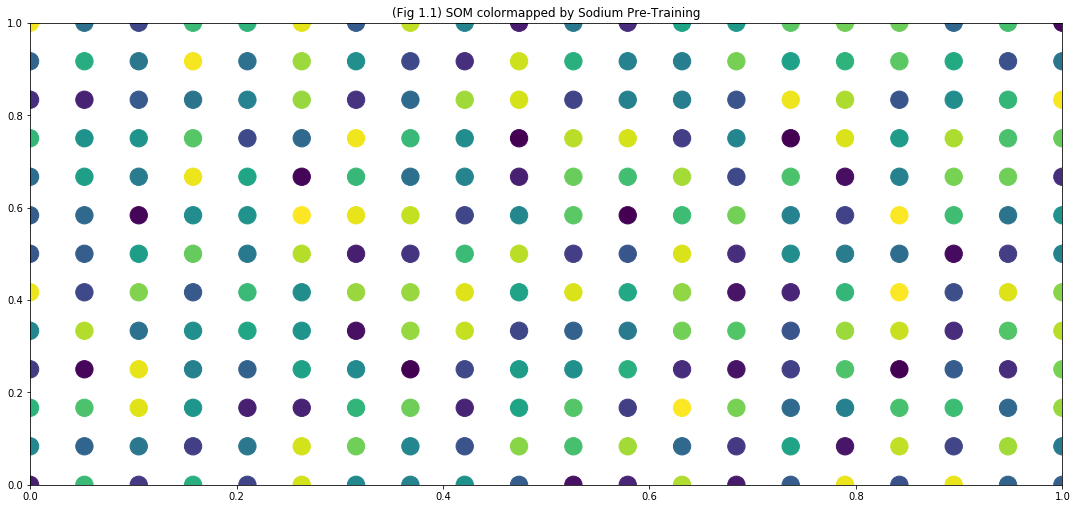

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(ld_nodes[:, 0], ld_nodes[:, 1] , c=hd_nodes[:,4],s=300)
axes = plt.gca()
axes.set_xlim([np.min(ld_nodes[:,0]),np.max(ld_nodes[:,0])])
axes.set_ylim([np.min(ld_nodes[:,1]),np.max(ld_nodes[:,1])])    
plt.title('(Fig 1.1) SOM colormapped by Sodium Pre-Training')
fig.set_size_inches(18.5,8.5)
plt.show()

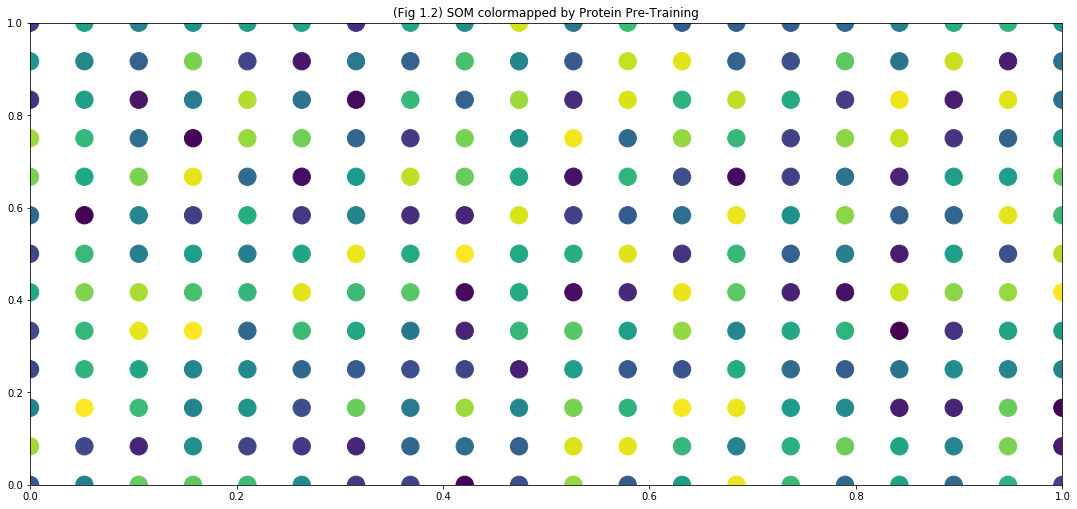

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(ld_nodes[:, 0], ld_nodes[:, 1] , c=hd_nodes[:,8],s=300)
axes = plt.gca()
axes.set_xlim([np.min(ld_nodes[:,0]),np.max(ld_nodes[:,0])])
axes.set_ylim([np.min(ld_nodes[:,1]),np.max(ld_nodes[:,1])])    
plt.title('(Fig 1.2) SOM colormapped by Protein Pre-Training')
fig.set_size_inches(18.5,8.5)
plt.show()

*  Fig 1.1 and Fig 1.2 indicate that the pre-trained high dimensional vectors do not reflect menu group types. Under the assumption that different menu types occupy different areas in the component space two positively correlated variables such as protein and sodium should produce plots that show random placement of groups i.e. no color neighborhoods, but similar colors on corresponding nodes between plots due to a positive strength and direction relationship between them. These plots appear random as expected which confirms that my High D node starting position is well dispersed.  

In [6]:
# SOM ALGORITHM
for i in range(100000):
    index = np.random.randint(0,260,1)
    target = (data_num_scaled[index])
    target_dist = cdist(hd_nodes,target,'euclidean')
    winning_node_index = np.argmin(target_dist)
    winning_node = np.array([ld_nodes[winning_node_index]])
    node_distances = cdist(ld_nodes,winning_node,'euclidean')
    gaussian = np.exp(-1*node_distances/0.03)
    update = (target - hd_nodes)*gaussian *0.3
    hd_nodes = hd_nodes + update

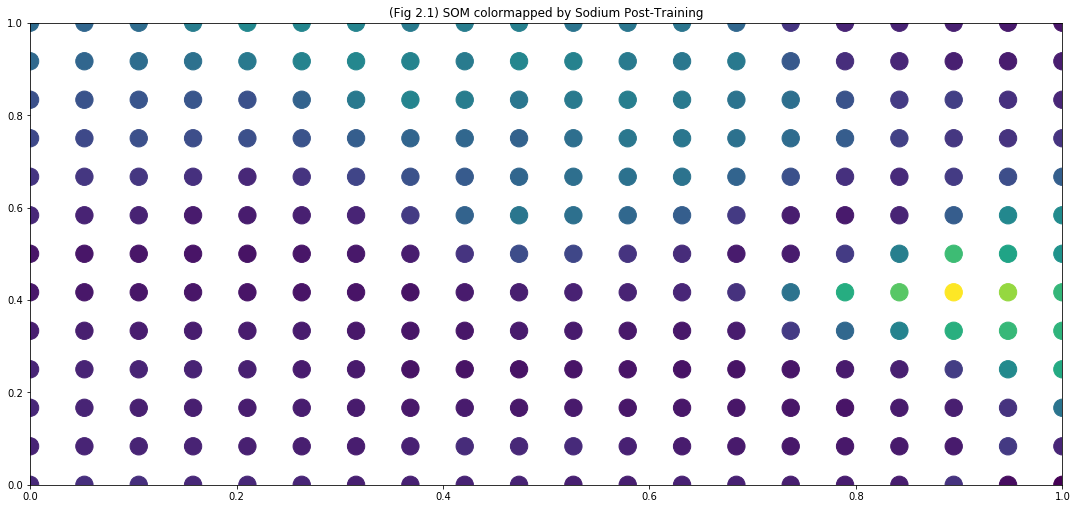

In [7]:
# SOM PLOT SODIUM
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(ld_nodes[:, 0], ld_nodes[:, 1] , c=hd_nodes[:,4],s=300)
axes = plt.gca()
axes.set_xlim([np.min(ld_nodes[:,0]),np.max(ld_nodes[:,0])])
axes.set_ylim([np.min(ld_nodes[:,1]),np.max(ld_nodes[:,1])])
plt.title('(Fig 2.1) SOM colormapped by Sodium Post-Training')
fig.set_size_inches(18.5,8.5)
plt.show()

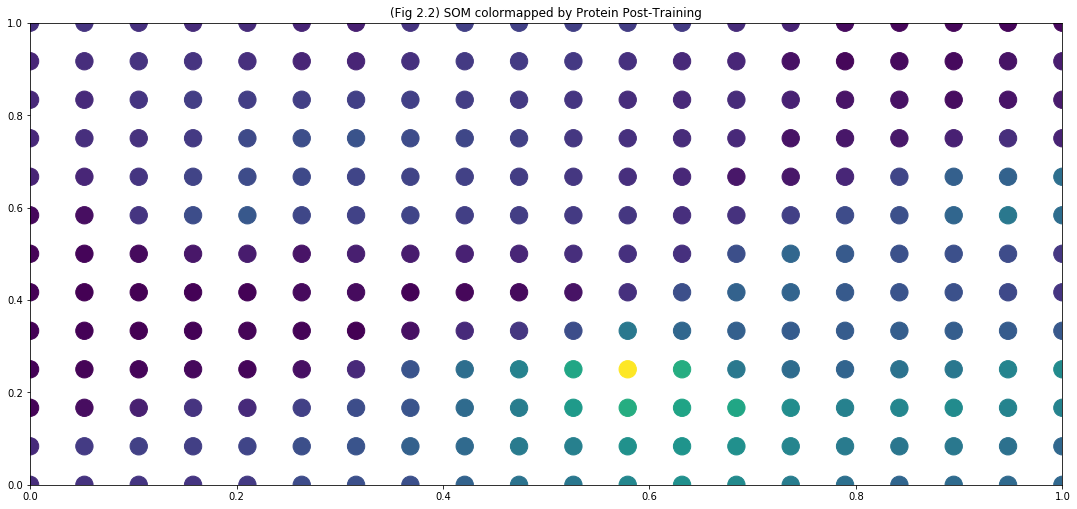

In [8]:
# SOM PLOT Protein
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(ld_nodes[:, 0], ld_nodes[:, 1] , c=hd_nodes[:,8],s=300)
axes = plt.gca()
axes.set_xlim([np.min(ld_nodes[:,0]),np.max(ld_nodes[:,0])])
axes.set_ylim([np.min(ld_nodes[:,1]),np.max(ld_nodes[:,1])])
plt.title('(Fig 2.2) SOM colormapped by Protein Post-Training')
fig.set_size_inches(18.5,8.5)
plt.show()

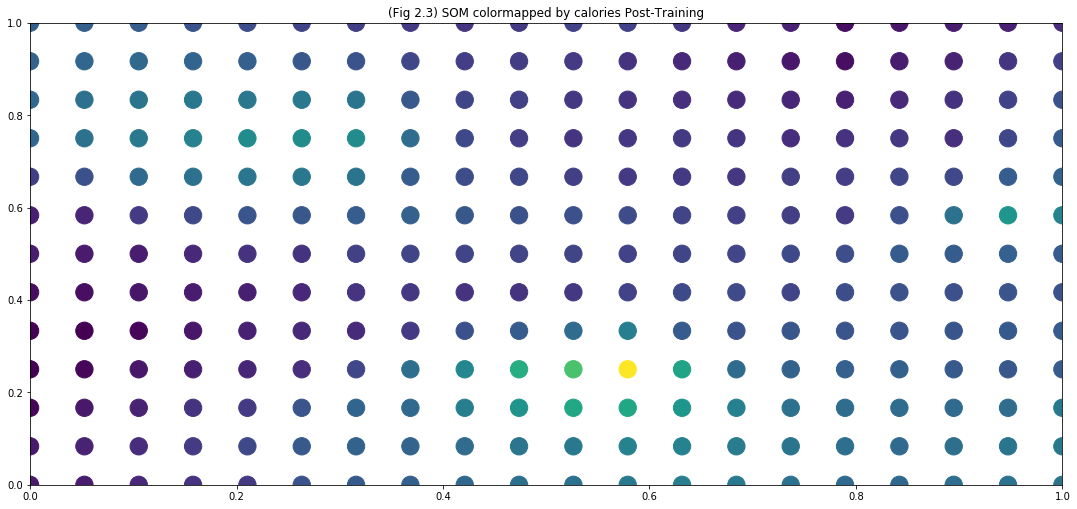

In [9]:
# SOM PLOT CALORIES
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(ld_nodes[:, 0], ld_nodes[:, 1] , c=hd_nodes[:,1],s=300)
axes = plt.gca()
axes.set_xlim([np.min(ld_nodes[:,0]),np.max(ld_nodes[:,0])])
axes.set_ylim([np.min(ld_nodes[:,1]),np.max(ld_nodes[:,1])])
plt.title('(Fig 2.3) SOM colormapped by calories Post-Training')
fig.set_size_inches(18.5,8.5)
plt.show()

In [10]:
# SOM ALGORITHM CORRELATION
for i in range(100000):
    index = np.random.randint(0,260,1)
    target = (data_num_scaled[index])
    target_dist = cdist(hd_nodes,target,'correlation')
    winning_node_index = np.argmin(target_dist)
    winning_node = np.array([ld_nodes[winning_node_index]])
    node_distances = cdist(ld_nodes,winning_node,'euclidean')
    gaussian = np.exp(-1*node_distances/0.03)
    update = (target - hd_nodes)*gaussian *0.3
    hd_nodes = hd_nodes + update

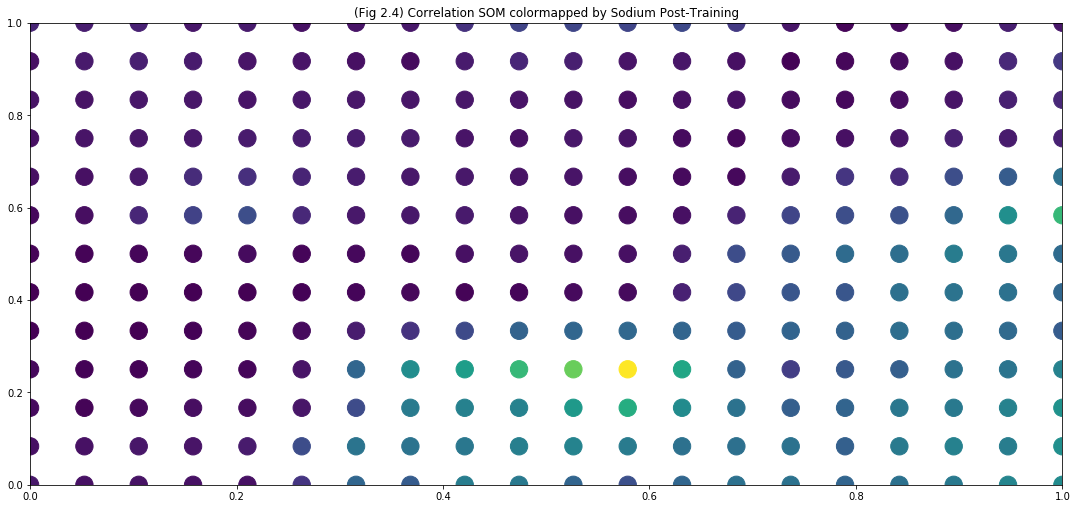

In [11]:
# SOM PLOT SODIUM
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(ld_nodes[:, 0], ld_nodes[:, 1] , c=hd_nodes[:,4],s=300)
axes = plt.gca()
axes.set_xlim([np.min(ld_nodes[:,0]),np.max(ld_nodes[:,0])])
axes.set_ylim([np.min(ld_nodes[:,1]),np.max(ld_nodes[:,1])])
plt.title('(Fig 2.4) Correlation SOM colormapped by Sodium Post-Training')
fig.set_size_inches(18.5,8.5)
plt.show()

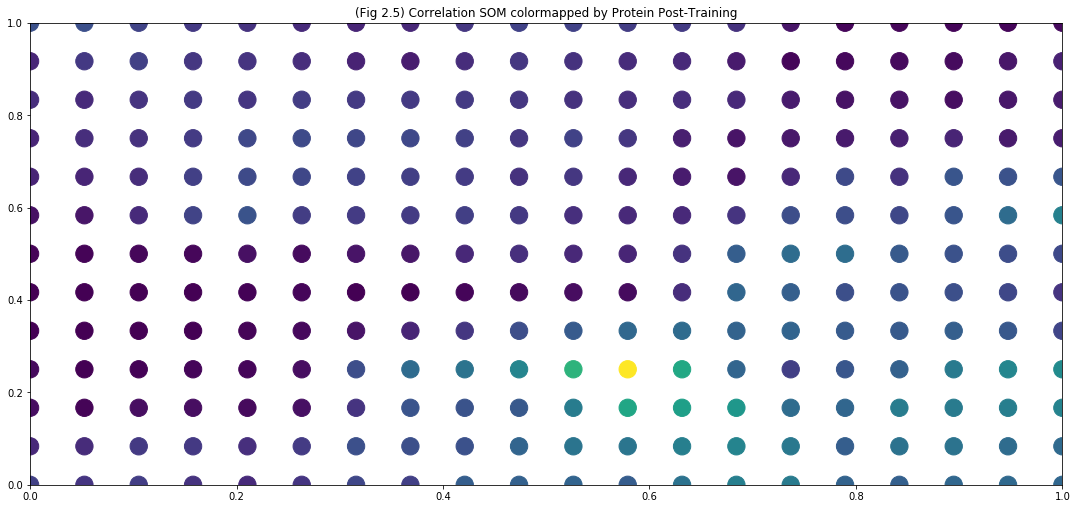

In [12]:
# SOM PLOT Protein
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(ld_nodes[:, 0], ld_nodes[:, 1] , c=hd_nodes[:,8],s=300)
axes = plt.gca()
axes.set_xlim([np.min(ld_nodes[:,0]),np.max(ld_nodes[:,0])])
axes.set_ylim([np.min(ld_nodes[:,1]),np.max(ld_nodes[:,1])])
plt.title('(Fig 2.5) Correlation SOM colormapped by Protein Post-Training')
fig.set_size_inches(18.5,8.5)
plt.show()

* Interestingly, using correlation as the measure of distance in the SOM algorithm appears to have produced a less ordered looking map. Figures 2.4 and 2.5 have noticeable similarity but the color gradient is not as smooth and the color neighborhoods are not as well defined. So, while correlation was useful to  between variables to try to orient myself on the previous maps, Euclidean distance may be better metric for producing an organized embedding of these data.

### Analysis
Fig's 2.1, 2.2 and 2.3 support the claim that the 2D mapping is capturing a notion of relative distance that corresponds to menu type groups. Since the color plots of the positively correlated variables protein, sodium and calories look similar and this analysis uses the assumption that nutrition profiles essentially define a menu type category, these maps provide evidence that the SOM is generating a map that embeds menu type in the distance between nodes. Ultimately, while I found the SOM interesting and it was fun to try to tease out some information from the plots, I could draw little insight from them without being able to know how close a given node vector is to a vector that is a part of a menu type group. I could find evidence that it is mapping something like menu type but without being able to tell what the corresponding categories are it's hard to say much about the plots. My TSNE analysis yielded more interpretable results for these data.

## TSNE
### Objectives for TSNE
The main objective of my TSNE experiment is again to try to create a 2D representation of how distant menu type groups are in component space. I expect that the TSNE will perform much better for this task because TSNE is mapping my actual data rather than random vectors approximating my data which means that I can preserve the labels. This way I will be able to make a much more meaningful interpretation of the plots. My hope is that the data will cluster by group types consistent with how a human might group them if asked to do so. Another objective of my experiment is to see how much additional components contribute to how tightly the data groups by menu type.  

In [13]:
# TSNE ALL FEATURES
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
fitted = tsne.fit_transform(data[:,4:13])
Y_Labeled = np.concatenate((fitted, data_cat),axis = 1)

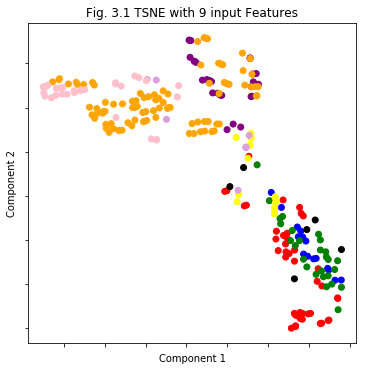

In [14]:
# PLOT TSNE ALL FEATURES
color_dict = {1:'red', 2:'blue', 3:'green', 4:'black', 5:'yellow', 6:'plum', 7:'purple', 8:'orange', 9:'pink'}
index = list(data_cat[:,1])
Y1 = list(fitted[:,0])
Y2 = list(fitted[:,1])
df = pd.DataFrame(dict(index=index, Y1=Y1, Y2=Y2))
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(331)
plt.scatter(df['Y1'], df['Y2'] , c=df['index'].apply(lambda x: color_dict[x]))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
plt.title('Fig. 3.1 TSNE with 9 input Features')
plt.axis('tight')
plt.show()

 * 1 = Red = Breakfast 
 * 2 = Blue = Beef&Pork 
 * 3 = Green = Chicken&Fish 
 * 4 = Black = Salads
 * 5 = Yellow = Snacks&Sides
 * 6 = plum = Desserts 
 * 7 = purple = Beverages 
 * 8 = orange = Coffee&Tea
 * 9 = pink = Smoothies

In [15]:
# TSNE WITHOUT SUGAR
x = data_num_scaled[:,0:7]
y = data_num_scaled[:,8:9]
data = np.concatenate((x,y), axis=1)

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
fitted = tsne.fit_transform(data)
Y_Labeled = np.concatenate((fitted, data_cat),axis = 1)

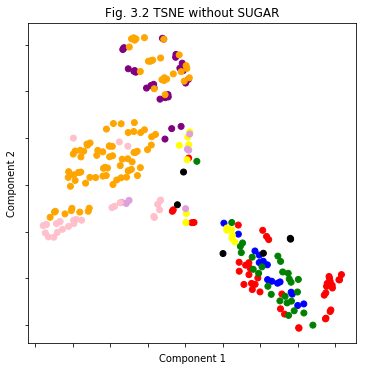

In [16]:
# PLOT TSNE WITHOUT SUGAR
Y1 = list(fitted[:,0])
Y2 = list(fitted[:,1])
df = pd.DataFrame(dict(index=index, Y1=Y1, Y2=Y2))
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(332)
plt.scatter(df['Y1'], df['Y2'] , c=df['index'].apply(lambda x: color_dict[x]))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
plt.title('Fig. 3.2 TSNE without SUGAR')
plt.axis('tight')
plt.show()

 * 1 = Red = Breakfast 
 * 2 = Blue = Beef&Pork 
 * 3 = Green = Chicken&Fish 
 * 4 = Black = Salads
 * 5 = Yellow = Snacks&Sides
 * 6 = plum = Desserts 
 * 7 = purple = Beverages 
 * 8 = orange = Coffee&Tea
 * 9 = pink = Smoothies

* The rotation of Fig 3.2 compared with 3.1 indicates that component two is capturing a notion of sweetness. The distance between Coffee&Tea and Beef&Pork (items with very disparate nutrional profiles) decreases mostly from movement in the y axis direction demonstrating that the effects of sugar contribute most to component 2.

In [17]:
# TSNE WITHOUT PROTEIN
data = data_num_scaled[:,0:8]

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
fitted = tsne.fit_transform(data)
Y_Labeled = np.concatenate((fitted, data_cat),axis = 1)

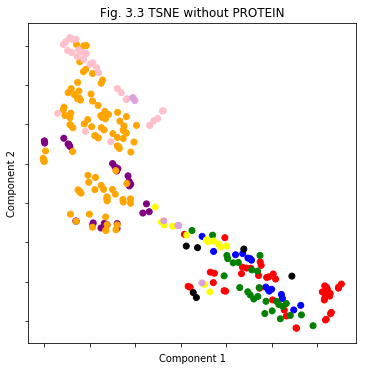

In [18]:
# PLOT TSNE WITHOUT PROTEIN
Y1 = list(fitted[:,0])
Y2 = list(fitted[:,1])
df = pd.DataFrame(dict(index=index, Y1=Y1, Y2=Y2))
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(333)
plt.scatter(df['Y1'], df['Y2'] , c=df['index'].apply(lambda x: color_dict[x]))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
plt.axis('tight')
plt.title('Fig. 3.3 TSNE without PROTEIN')
plt.show()

 * 1 = Red = Breakfast 
 * 2 = Blue = Beef&Pork 
 * 3 = Green = Chicken&Fish 
 * 4 = Black = Salads
 * 5 = Yellow = Snacks&Sides
 * 6 = plum = Desserts 
 * 7 = purple = Beverages 
 * 8 = orange = Coffee&Tea
 * 9 = pink = Smoothies

In [19]:
# TSNE WITHOUT SODIUM
Y1 = list(fitted[:,0])
Y2 = list(fitted[:,1])
df = pd.DataFrame(dict(index=index, Y1=Y1, Y2=Y2))
x = data_num_scaled[:,0:4]
y = data_num_scaled[:,5:9]
data = np.concatenate((x,y), axis=1)

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
fitted = tsne.fit_transform(data)
Y_Labeled = np.concatenate((fitted, data_cat),axis = 1)

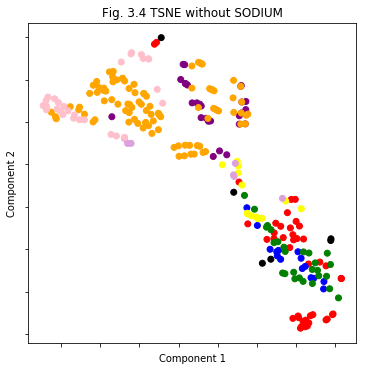

In [20]:
# PLOT TSNE WITHOUT SODIUM
Y1 = list(fitted[:,0])
Y2 = list(fitted[:,1])
df = pd.DataFrame(dict(index=index, Y1=Y1, Y2=Y2))
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(334)
plt.scatter(df['Y1'], df['Y2'] , c=df['index'].apply(lambda x: color_dict[x]))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
plt.title('Fig. 3.4 TSNE without SODIUM')
plt.axis('tight')
plt.show()

 * 1 = Red = Breakfast 
 * 2 = Blue = Beef&Pork 
 * 3 = Green = Chicken&Fish 
 * 4 = Black = Salads
 * 5 = Yellow = Snacks&Sides
 * 6 = plum = Desserts 
 * 7 = purple = Beverages 
 * 8 = orange = Coffee&Tea
 * 9 = pink = Smoothies

   * Fig 3.4 shows a salad item and a breakfast item that are more closely related to beverages and smoothies when the effects of sodium are not accounted for. Those are likely items with high sugar content and high sodium. 

In [21]:
# TSNE WITHOUT CARBS
x = data_num_scaled[:,0:5]
y = data_num_scaled[:,6:9]
data = np.concatenate((x,y), axis=1)

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
fitted = tsne.fit_transform(data)
Y_Labeled = np.concatenate((fitted, data_cat),axis = 1)

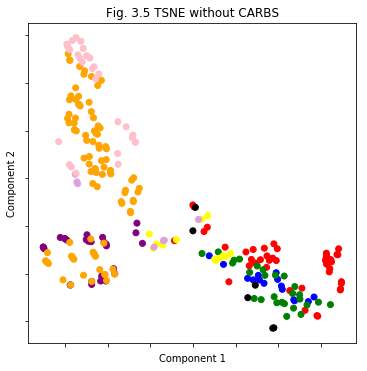

In [22]:
# PLOT TSNE WITHOUT CARBS
Y1 = list(fitted[:,0])
Y2 = list(fitted[:,1])
df = pd.DataFrame(dict(index=index, Y1=Y1, Y2=Y2))
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(335)
plt.scatter(df['Y1'], df['Y2'] , c=df['index'].apply(lambda x: color_dict[x]))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
plt.title('Fig. 3.5 TSNE without CARBS')
plt.axis('tight')
plt.show()

 * 1 = Red = Breakfast 
 * 2 = Blue = Beef&Pork 
 * 3 = Green = Chicken&Fish 
 * 4 = Black = Salads
 * 5 = Yellow = Snacks&Sides
 * 6 = plum = Desserts 
 * 7 = purple = Beverages 
 * 8 = orange = Coffee&Tea
 * 9 = pink = Smoothies

 * Running the model without the Carbs component flips the positon of the smooties/coffee&tea cluster with the coffe&tea/beverages cluster. The coffe&tea/beverages moved a very large distance in the component 2 direction which indicates carbs are a large contributor to that component.

In [23]:
# TSNE WITH FAT, SODIUM, SUGAR, PROTEIN
w = data_num_scaled[:,2:3]
x = data_num_scaled[:,4:5]
y = data_num_scaled[:,7:8]
z = data_num_scaled[:,8:9]
data = np.concatenate((w,x,y,z), axis=1)

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
fitted = tsne.fit_transform(data)
Y_Labeled = np.concatenate((fitted, data_cat),axis = 1)

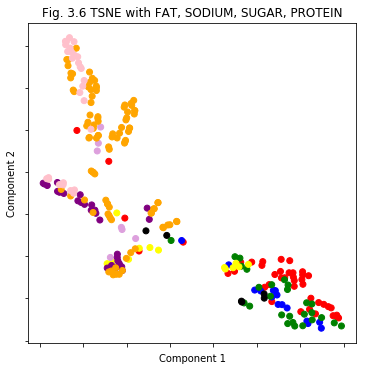

In [24]:
# PLOT TSNE WITH FAT, SODIUM, SUGAR, PROTEIN
Y1 = list(fitted[:,0])
Y2 = list(fitted[:,1])
df = pd.DataFrame(dict(index=index, Y1=Y1, Y2=Y2))
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(336)
plt.scatter(df['Y1'], df['Y2'] , c=df['index'].apply(lambda x: color_dict[x]))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
plt.title('Fig. 3.6 TSNE with FAT, SODIUM, SUGAR, PROTEIN')
plt.axis('tight')
plt.show()

 * 1 = Red = Breakfast 
 * 2 = Blue = Beef&Pork 
 * 3 = Green = Chicken&Fish 
 * 4 = Black = Salads
 * 5 = Yellow = Snacks&Sides
 * 6 = plum = Desserts 
 * 7 = purple = Beverages 
 * 8 = orange = Coffee&Tea
 * 9 = pink = Smoothies

### Analysis
The TSNE graphs reveal several notable properties of these data. First, the clustering is robust to losing components and still maintaining its approximate shape and color groupings by meal type. To my eye, the graphs keep a "tomahawk" shape that rotates or mirrors at the base of the "handle" using different combinations of input components. I was surprised to find that the clusters were so consistent across model runs with seemingly important variables missing. The notion of distance used by the TSNE algorithm appears to be preserving the local structure of the data as clusters which are then located on the map in different positions based on what input components it had to work with. The positions change but the clusters remain.

To get at this further I wanted to see how the model performed with just a few important variables. If certain variables are strongly correlated in food (prior knowledge about nutrition suggests they are) a large portion of the distance information would be captured by using just a few relatively uncorrelated components and the general shape should stay intact because additional correlated variables are largely agreeing with the placement of the points on the map anyway. This is illustrated by Fig. 3.6 which uses just 4 of the original 9 components and does roughly maintain a similar shape to the other models. While the broad strokes can be captured by just a few dimensions, the extra dimensions do contribute useful distance information. Fig 3.1 contains the most components and also looks to me to be the most orderly plot. The additional information provided by the rest of the components helped refine the clustering as well as position the clusters on the plot in perhaps a more intuitive way. 
 
Another main benefit of dimensionality reduction, which is apparent in this analysis, is that a model can capture the effect of latent variables that can't be directly measured but rather are understood through the aggregation of contributing factors. This is really at the heart of what I set out to do with this data. I wanted to see if the models would portray the distance relationships between menu items the way a human might if asked to do so. For example, when I think of a concept I would expect to be captured in a mapping of the McD's menu I think of a notion of sweet vs savory. Being able to capture of the cumulative effects of fat, protein and sodium in the 2D mapping might help get at that more nebulous idea of savory for instance. I think each TSNE I ran captured that dichotomy well and for the most part they grouped items much in a way a human might have. Ultimately, I think I accomplished what I set out to do which was identify a dataset that I could use my intuition as a human to map, observe that the computer mapping is consistent with the intuition and thereby confirm that I understand what kind of data this technique is useful for and that it works as I expect it to. Thus, in the future with data where I am truly looking for insight, I can draw conclusions from these models with confidence knowing that the models were able to detect distance relationships that would be meaningful to me as a human with a tongue.